Суть задачи в следующем: есть производство полиэтиленовой пленки. Само производство очень распространено в России и выглядит относительно просто (гуглится) – грубо говоря, засыпаются гранулы пропилена, их расплавляют, вытягивают, собирают в большой цилиндр (на фото в приложенных документах) – раскатывают, нарезают. Более детальный процесс пр-ва довольно легко найти в интернете.

Суть в том, что иногда происходят обрывы этой пленки. Хочется исследовать как зависят эти обрывы от режима пр-ва, от рецептур.

По ссылке есть данные с оборудования экструдера – теги телеметрии за год. Во вложении – описание этих тегов на русском языке. Обрывность пленки можно найти по тегу «толщина» - (ST110_VAREx_0_SDickeIst).

Собственно, что нужно сделать:

- Разобраться в том, как выглядит пр-во пленки
- Разобраться с тегами, понять, что какой означает (скорее – «догадаться»)
- Посмотреть на статистику обрывности
- Найти набор параметров, которые характеризуют режим пр-ва, рецептуру
- Поисследовать – как влияют эти параметры на обрывность

###  Задача не сложная... будем использовать бустинг (данных хватает, чтобы использовать не классический алгоритмы) + SVD разложение (для снижения размерности) + смещение по времени (тут опять же бустинг будет работать с лагами лучше)

In [1]:
import numpy as np 
import pandas as pd 
import pandas_profiling
import pandas_summary as ps

# Data processing, metrics and modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.impute import SimpleImputer

# Lgbm
import lightgbm as lgb

# Suppr warning
import warnings
warnings.filterwarnings("ignore")

# Plots
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Others
import shap
import datetime
from tqdm import tqdm_notebook
import sys
import pickle
import re
import json
import gc

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('use_inf_as_na', True)

warnings.simplefilter('ignore')
matplotlib.rcParams['figure.dpi'] = 100
sns.set()
%matplotlib inline

In [2]:
folder = ''
stats_df = pd.read_csv(folder + 'Zusammengefuhrte_daten_2019 - Stats.csv', sep=';')
full_df = pd.read_csv(folder + 'Zusammengefuhrte_daten_2019.csv', sep=';')
#tags_df = pd.read_excel(folder + 'Zusammengefuhrte_daten_2019.csv')

In [3]:
stats_df.shape, full_df.shape

((469, 3), (226542, 470))

In [4]:
stats_df.head()

Tags        Mean         Var
0                       ST0_VARActAuftrag    0.000000    0.000000
1  ST110_VARExtr_0_HeizungZone_3_Regler_Y    3.033738   55.673467
2  ST110_VARExtr_0_HeizungZone_3_SollTemp  176.070130  273.909321
3    ST110_VARExtr_0_HeizungZone_4_Konfig    1.000000    0.000000
4  ST110_VARExtr_0_HeizungZone_4_Regler_X  184.111635  455.741691

In [5]:
stats_df.tail()

Tags       Mean         Var
464        ST114_VARWdSpSpeed   0.000000    0.000000
465         ST114_VARWdSpTens  69.033077  534.431833
466        ST114_VARWdTapeNum   5.000000    0.000000
467  ST114_VARWdTapeReductVal  15.000000    0.000000
468        ST114_VARWdTensVis  57.277305  988.178362

In [6]:
#columns_for_train_full = [c for c in stats_df['Tags'].tolist() if c not in ('ST110_VAREx_0_SDickeIst')]
#columns_for_train_full = [c for c in stats_df['Tags'].tolist() if 'ST110_' not in c]
#columns_for_train = [c for c in stats_df['Tags'].tolist() if 'ST110_' not in c]
columns_for_train = [c for c in stats_df['Tags'].tolist() if c not in ('ST110_VAREx_0_SDickeIst', 'ST110_VAREx_0_SDickeIst')]
column_target = ['ST110_VAREx_0_SDickeIst',]

In [7]:
full_df.head()

Datum  ST0_VARActAuftrag  ST110_VARExtr_0_HeizungZone_3_Regler_Y  ST110_VARExtr_0_HeizungZone_3_SollTemp  ST110_VARExtr_0_HeizungZone_4_Konfig  ST110_VARExtr_0_HeizungZone_4_Regler_X  ST110_VARExtr_0_HeizungZone_4_Regler_Y  ST110_VARExtr_0_HeizungZone_4_SollTemp  ST110_VARExtr_0_HeizungZone_5_Konfig  ST110_VARExtr_0_HeizungZone_5_Regler_X  ST110_VARExtr_0_HeizungZone_5_Regler_Y  ST110_VARExtr_0_HeizungZone_5_SollTemp  ST110_VARExtr_0_HeizungZone_6_Konfig  ST110_VARExtr_0_HeizungZone_6_Regler_X  ST110_VARExtr_0_HeizungZone_6_Regler_Y  ST110_VARExtr_0_HeizungZone_6_SollTemp  ST110_VARExtr_0_HeizungZone_7_Konfig  ST110_VARExtr_0_HeizungZone_7_Regler_X  ST110_VARExtr_0_HeizungZone_7_Regler_Y  ST110_VARExtr_0_HeizungZone_7_SollTemp  ST110_VARExtr_0_HeizungZone_8_Konfig  ST110_VARExtr_0_HeizungZone_8_Regler_X  ST110_VARExtr_0_HeizungZone_8_Regler_Y  ST110_VARExtr_0_HeizungZone_8_SollTemp  ST110_VARExtr_0_HeizungZone_9_Konfig  ST110_VARExtr_0_HeizungZone_9_Regler_X  \
0  25.06.2018 4:27                0.0                                     9.0                                   190.0                                   1.0                                   193.0                                     0.0                                   190.0                                   1.0                                   190.0                                    24.0                                   190.0                                   0.0                                    32.0                                     0.0                                   150.0                                   0.0                                    33.0                                     0.0                                   150.0                                   0.0                                    33.0                                     0.0                                   150.0                                   0.0                                    32.0   
1  25.06.2018 4:29                0.0                                    10.0                                   190.0                                   1.0                                   193.0                                     0.0                                   190.0                                   1.0                                   190.0                                    23.0                                   190.0                                   0.0                                    32.0                                     0.0                                   150.0                                   0.0                                    33.0                                     0.0                                   150.0                                   0.0                                    33.0                                     0.0                                   150.0                                   0.0                                    32.0   
2  25.06.2018 4:32                0.0                                    10.0                                   190.0                                   1.0                                   193.0                                     0.0                                   190.0                                   1.0                                   190.0                                    24.0                                   190.0                                   0.0                                    32.0                                     0.0                                   150.0                                   0.0                                    33.0                                     0.0                                   150.0                                   0.0                                    33.0                                     0.0                                   150.0                                   0.0                                    32.0   
3  25.06.2018 4:34                0.0                    

In [8]:
full_df.tail()

Datum  ST0_VARActAuftrag  ST110_VARExtr_0_HeizungZone_3_Regler_Y  ST110_VARExtr_0_HeizungZone_3_SollTemp  ST110_VARExtr_0_HeizungZone_4_Konfig  ST110_VARExtr_0_HeizungZone_4_Regler_X  ST110_VARExtr_0_HeizungZone_4_Regler_Y  ST110_VARExtr_0_HeizungZone_4_SollTemp  ST110_VARExtr_0_HeizungZone_5_Konfig  ST110_VARExtr_0_HeizungZone_5_Regler_X  ST110_VARExtr_0_HeizungZone_5_Regler_Y  ST110_VARExtr_0_HeizungZone_5_SollTemp  ST110_VARExtr_0_HeizungZone_6_Konfig  ST110_VARExtr_0_HeizungZone_6_Regler_X  ST110_VARExtr_0_HeizungZone_6_Regler_Y  ST110_VARExtr_0_HeizungZone_6_SollTemp  ST110_VARExtr_0_HeizungZone_7_Konfig  ST110_VARExtr_0_HeizungZone_7_Regler_X  ST110_VARExtr_0_HeizungZone_7_Regler_Y  ST110_VARExtr_0_HeizungZone_7_SollTemp  ST110_VARExtr_0_HeizungZone_8_Konfig  ST110_VARExtr_0_HeizungZone_8_Regler_X  ST110_VARExtr_0_HeizungZone_8_Regler_Y  ST110_VARExtr_0_HeizungZone_8_SollTemp  ST110_VARExtr_0_HeizungZone_9_Konfig  ST110_VARExtr_0_HeizungZone_9_Regler_X  \
226537  25.06.2019 6:36                0.0                                     2.0                                   165.0                                   1.0                                   170.0                                     0.0                                   165.0                                   1.0                                   165.0                                    16.0                                   165.0                                   0.0                                    38.0                                     0.0                                   150.0                                   0.0                                    40.0                                     0.0                                   150.0                                   0.0                                    39.0                                     0.0                                   150.0                                   0.0                                    39.0   
226538  25.06.2019 6:38                0.0                                     2.0                                   165.0                                   1.0                                   170.0                                     0.0                                   165.0                                   1.0                                   165.0                                    15.0                                   165.0                                   0.0                                    38.0                                     0.0                                   150.0                                   0.0                                    40.0                                     0.0                                   150.0                                   0.0                                    39.0                                     0.0                                   150.0                                   0.0                                    39.0   
226539  25.06.2019 6:40                0.0                                     2.0                                   165.0                                   1.0                                   170.0                                     0.0                                   165.0                                   1.0                                   165.0                                    15.0                                   165.0                                   0.0                                    38.0                                     0.0                                   150.0                                   0.0                                    40.0                                     0.0                                   150.0                                   0.0                                    39.0                                     0.0                                   150.0                                   0.0                                    39.0   
226540  25.06.2019 6:42                0.0

In [9]:
full_df['Datum'] = pd.to_datetime(full_df['Datum'])

In [10]:
full_df = full_df.reset_index()

In [11]:
full_df.index = full_df['Datum'] 

In [12]:
full_df.head()

index               Datum  ST0_VARActAuftrag  ST110_VARExtr_0_HeizungZone_3_Regler_Y  ST110_VARExtr_0_HeizungZone_3_SollTemp  ST110_VARExtr_0_HeizungZone_4_Konfig  ST110_VARExtr_0_HeizungZone_4_Regler_X  ST110_VARExtr_0_HeizungZone_4_Regler_Y  ST110_VARExtr_0_HeizungZone_4_SollTemp  ST110_VARExtr_0_HeizungZone_5_Konfig  ST110_VARExtr_0_HeizungZone_5_Regler_X  ST110_VARExtr_0_HeizungZone_5_Regler_Y  ST110_VARExtr_0_HeizungZone_5_SollTemp  ST110_VARExtr_0_HeizungZone_6_Konfig  ST110_VARExtr_0_HeizungZone_6_Regler_X  ST110_VARExtr_0_HeizungZone_6_Regler_Y  ST110_VARExtr_0_HeizungZone_6_SollTemp  ST110_VARExtr_0_HeizungZone_7_Konfig  ST110_VARExtr_0_HeizungZone_7_Regler_X  ST110_VARExtr_0_HeizungZone_7_Regler_Y  ST110_VARExtr_0_HeizungZone_7_SollTemp  ST110_VARExtr_0_HeizungZone_8_Konfig  ST110_VARExtr_0_HeizungZone_8_Regler_X  ST110_VARExtr_0_HeizungZone_8_Regler_Y  ST110_VARExtr_0_HeizungZone_8_SollTemp  ST110_VARExtr_0_HeizungZone_9_Konfig  \
Datum                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-06-25 04:27:00      0 2018-06-25 04:27:00                0.0                                     9.0                                   190.0                                   1.0                                   193.0                                     0.0                                   190.0                                   1.0                                   190.0                                    24.0                                   190.0                                   0.0                                    32.0                                     0.0                                   150.0                                   0.0                                    33.0                                     0.0                                   150.0                                   0.0                                    33.0                                     0.0                                   150.0                                   0.0   
2018-06-25 04:29:00      1 2018-06-25 04:29:00                0.0                                    10.0                                   190.0                                   1.0                                   193.0                                     0.0                                   190.0                                   1.0                                   190.0                                    23.0                                   190.0                                   0.0                                    32.0                                     0.0                                   150.0                                   0.0                                    33.0                                     0.0                                   150.0                                   0.0                                    33.0                                     0.0                                   150.0                                   0.0   
2018-06-25 04:32:00      2 2018-06-25 04:32:00                0.0                                    10.0        

### Используя pandas_summary посмотрим расширенный describe по колонкам

In [13]:
dfs = ps.DataFrameSummary(full_df)
print('categoricals: ', dfs.categoricals.tolist())
print('numerics: ', dfs.numerics.tolist())
dfs.summary()

categoricals:  []


numerics:  ['index', 'ST110_VARExtr_0_HeizungZone_3_Regler_Y', 'ST110_VARExtr_0_HeizungZone_3_SollTemp', 'ST110_VARExtr_0_HeizungZone_4_Regler_X', 'ST110_VARExtr_0_HeizungZone_4_Regler_Y', 'ST110_VARExtr_0_HeizungZone_4_SollTemp', 'ST110_VARExtr_0_HeizungZone_5_Regler_X', 'ST110_VARExtr_0_HeizungZone_5_Regler_Y', 'ST110_VARExtr_0_HeizungZone_5_SollTemp', 'ST110_VARExtr_0_HeizungZone_6_Regler_X', 'ST110_VARExtr_0_HeizungZone_7_Regler_X', 'ST110_VARExtr_0_HeizungZone_8_Regler_X', 'ST110_VARExtr_0_HeizungZone_9_Regler_X', 'ST110_VARExtr_1_druck_1_IstP', 'ST110_VARExtr_1_HeizungZone_1_ActEffectPower', 'ST110_VARExtr_1_HeizungZone_1_Regler_X', 'ST110_VARExtr_1_HeizungZone_1_Regler_Y', 'ST110_VARExtr_1_HeizungZone_1_SollTemp', 'ST110_VARExtr_1_HeizungZone_2_ActEffectPower', 'ST110_VARExtr_1_HeizungZone_2_Regler_X', 'ST110_VARExtr_1_HeizungZone_2_Regler_Y', 'ST110_VARExtr_1_HeizungZone_2_SollTemp', 'ST110_VARExtr_1_HeizungZone_3_ActEffectPower', 'ST110_VARExtr_1_HeizungZone_3_Regler_X', 'ST11

index   Datum ST0_VARActAuftrag ST110_VARExtr_0_HeizungZone_3_Regler_Y ST110_VARExtr_0_HeizungZone_3_SollTemp ST110_VARExtr_0_HeizungZone_4_Konfig ST110_VARExtr_0_HeizungZone_4_Regler_X ST110_VARExtr_0_HeizungZone_4_Regler_Y ST110_VARExtr_0_HeizungZone_4_SollTemp ST110_VARExtr_0_HeizungZone_5_Konfig ST110_VARExtr_0_HeizungZone_5_Regler_X ST110_VARExtr_0_HeizungZone_5_Regler_Y ST110_VARExtr_0_HeizungZone_5_SollTemp ST110_VARExtr_0_HeizungZone_6_Konfig ST110_VARExtr_0_HeizungZone_6_Regler_X ST110_VARExtr_0_HeizungZone_6_Regler_Y ST110_VARExtr_0_HeizungZone_6_SollTemp ST110_VARExtr_0_HeizungZone_7_Konfig ST110_VARExtr_0_HeizungZone_7_Regler_X ST110_VARExtr_0_HeizungZone_7_Regler_Y ST110_VARExtr_0_HeizungZone_7_SollTemp ST110_VARExtr_0_HeizungZone_8_Konfig ST110_VARExtr_0_HeizungZone_8_Regler_X ST110_VARExtr_0_HeizungZone_8_Regler_Y ST110_VARExtr_0_HeizungZone_8_SollTemp ST110_VARExtr_0_HeizungZone_9_Konfig ST110_VARExtr_0_HeizungZone_9_Regler_X  \
count          226542     NaN            226542                                 226480                                 226480                               226480                                 226480                                 226480                                 226480                               226480                                 226480                                 226480                                 226480                               226480                                 226480                                 226480                                 226480                               226480                                 226480                                 226480                                 226480                               226480                                 226480                                 226480                                 226480                               226480                                 226480   
mean           113270     NaN                 0                                3.03374                                 176.07                                    1                                184.112                               0.565525                                176.238                                    1                                 176.36                                11.2202                                176.333                                    0                                36.3119                                      0                                148.634                                    0                                37.6439                                      0                                148.634                                    0                                 37.204                                      0                                148.634                                    0                                36.6409   
std           65397.2     NaN                 0                                7.46147                                16.5502                                    0                                21.3481                                3.58555                                16.5695                                    0                                20.9542                                 9.5453                                16.7958                                    0                                4.03771                                      0                                8.14981                                    0                                4.21344                                      0                                8.14981                                    0                                4.16757                                      0                                8.14981                                    0                                4.15897   
min                 0     NaN                 0                                      0                              

## Статистика обрывности. Посмотрим на распределение таргета.

In [14]:
stats_df[(stats_df['Tags'] == 'ST110_VAREx_0_SDickeIst')]

Tags       Mean        Var
157  ST110_VAREx_0_SDickeIst  39.219406  722.15652

### Тут производство почти непрерывно. Простои присутствуют как правило после обрыва пленки или по другим причинам (другие не важны для задачи).

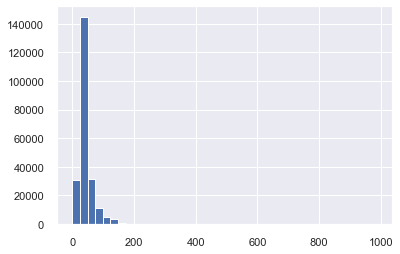

In [15]:
full_df['ST110_VAREx_0_SDickeIst'].hist(bins=40);

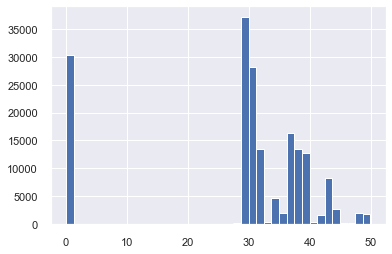

In [16]:
full_df[full_df['ST110_VAREx_0_SDickeIst'] < 50]['ST110_VAREx_0_SDickeIst'].hist(bins=40);

In [17]:
full_df[(full_df['ST110_VAREx_0_SDickeIst'] < 28)]['ST110_VAREx_0_SDickeIst'].value_counts()

0.0     30328
27.9        6
21.8        5
25.2        4
24.8        4
14.6        3
27.7        3
26.3        3
23.3        2
27.6        2
17.7        2
25.8        2
25.6        2
26.7        2
27.8        2
26.1        2
22.6        2
7.1         2
25.4        1
27.0        1
16.2        1
21.3        1
23.1        1
14.2        1
20.2        1
20.3        1
24.9        1
11.1        1
13.2        1
4.6         1
5.1         1
22.9        1
22.5        1
27.2        1
10.5        1
21.7        1
12.3        1
19.4        1
14.8        1
26.2        1
21.6        1
25.0        1
20.6        1
23.6        1
21.4        1
23.2        1
8.9         1
23.4        1
10.8        1
5.5         1
19.9        1
27.4        1
15.4        1
24.7        1
15.5        1
20.9        1
24.2        1
27.5        1
5.9         1
17.4        1
21.2        1
25.5        1
25.3        1
17.1        1
15.1        1
4.4         1
26.9        1
21.0        1
14.3        1
22.4        1
24.5        1
24.1  

In [18]:
full_df[(full_df['ST110_VAREx_0_SDickeIst'] > 0)].shape[0]

196152

### Бинарка. Так как производство непрерывно, часто встречаются случаи, когда обрыв пленки идет по метрики несколько периодов подряд. Чтобы не переобучиться будем разбивать на трейн в гораздо меньшей пропорции по сравнению с валидацией, об этом далее.

In [19]:
full_df['ST110_VAREx_0_SDickeIst'].apply(lambda x: 1 if x == 0 else 0).value_counts(normalize=True)

0    0.866126
1    0.133874
Name: ST110_VAREx_0_SDickeIst, dtype: float64

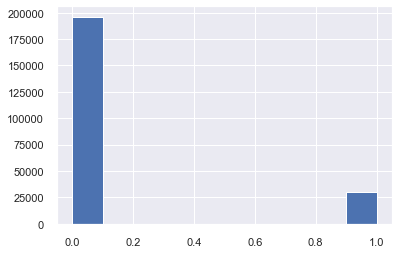

In [20]:
full_df['ST110_VAREx_0_SDickeIst'].apply(lambda x: 1 if x == 0 else 0).hist();

In [21]:
full_df[['ST110_VAREx_0_SDickeIst']].describe()

ST110_VAREx_0_SDickeIst
count            226480.000000
mean                 39.219406
std                  26.872970
min                   0.000000
25%                  29.500000
50%                  34.200000
75%                  44.000000
max                 986.500000

## Проверим как будем джоинить по timelag

In [22]:
tmp_df = full_df.shift(periods = 30).dropna()
tmp_df

index               Datum  ST0_VARActAuftrag  ST110_VARExtr_0_HeizungZone_3_Regler_Y  ST110_VARExtr_0_HeizungZone_3_SollTemp  ST110_VARExtr_0_HeizungZone_4_Konfig  ST110_VARExtr_0_HeizungZone_4_Regler_X  ST110_VARExtr_0_HeizungZone_4_Regler_Y  ST110_VARExtr_0_HeizungZone_4_SollTemp  ST110_VARExtr_0_HeizungZone_5_Konfig  ST110_VARExtr_0_HeizungZone_5_Regler_X  ST110_VARExtr_0_HeizungZone_5_Regler_Y  ST110_VARExtr_0_HeizungZone_5_SollTemp  ST110_VARExtr_0_HeizungZone_6_Konfig  ST110_VARExtr_0_HeizungZone_6_Regler_X  ST110_VARExtr_0_HeizungZone_6_Regler_Y  ST110_VARExtr_0_HeizungZone_6_SollTemp  ST110_VARExtr_0_HeizungZone_7_Konfig  ST110_VARExtr_0_HeizungZone_7_Regler_X  ST110_VARExtr_0_HeizungZone_7_Regler_Y  ST110_VARExtr_0_HeizungZone_7_SollTemp  ST110_VARExtr_0_HeizungZone_8_Konfig  ST110_VARExtr_0_HeizungZone_8_Regler_X  ST110_VARExtr_0_HeizungZone_8_Regler_Y  ST110_VARExtr_0_HeizungZone_8_SollTemp  ST110_VARExtr_0_HeizungZone_9_Konfig  \
Datum                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2018-06-25 05:32:00       0.0 2018-06-25 04:27:00                0.0                                     9.0                                   190.0                                   1.0                                   193.0                                     0.0                                   190.0                                   1.0                                   190.0                                    24.0                                   190.0                                   0.0                                    32.0                                     0.0                                   150.0                                   0.0                                    33.0                                     0.0                                   150.0                                   0.0                                    33.0                                     0.0                                   150.0                                   0.0   
2018-06-25 05:34:00       1.0 2018-06-25 04:29:00                0.0                                    10.0                                   190.0                                   1.0                                   193.0                                     0.0                                   190.0                                   1.0                                   190.0                                    23.0                                   190.0                                   0.0                                    32.0                                     0.0                                   150.0                                   0.0                                    33.0                                     0.0                                   150.0                                   0.0                                    33.0                                     0.0                                   150.0                                   0.0   
2018-06-25 05:37:00       2.0 2018-06-25 04:32:00                0.0                                    

In [23]:
tmp_df = full_df.groupby(pd.Grouper(freq='90Min', label='right')).first()
tmp_df

index               Datum  ST0_VARActAuftrag  ST110_VARExtr_0_HeizungZone_3_Regler_Y  ST110_VARExtr_0_HeizungZone_3_SollTemp  ST110_VARExtr_0_HeizungZone_4_Konfig  ST110_VARExtr_0_HeizungZone_4_Regler_X  ST110_VARExtr_0_HeizungZone_4_Regler_Y  ST110_VARExtr_0_HeizungZone_4_SollTemp  ST110_VARExtr_0_HeizungZone_5_Konfig  ST110_VARExtr_0_HeizungZone_5_Regler_X  ST110_VARExtr_0_HeizungZone_5_Regler_Y  ST110_VARExtr_0_HeizungZone_5_SollTemp  ST110_VARExtr_0_HeizungZone_6_Konfig  ST110_VARExtr_0_HeizungZone_6_Regler_X  ST110_VARExtr_0_HeizungZone_6_Regler_Y  ST110_VARExtr_0_HeizungZone_6_SollTemp  ST110_VARExtr_0_HeizungZone_7_Konfig  ST110_VARExtr_0_HeizungZone_7_Regler_X  ST110_VARExtr_0_HeizungZone_7_Regler_Y  ST110_VARExtr_0_HeizungZone_7_SollTemp  ST110_VARExtr_0_HeizungZone_8_Konfig  ST110_VARExtr_0_HeizungZone_8_Regler_X  ST110_VARExtr_0_HeizungZone_8_Regler_Y  ST110_VARExtr_0_HeizungZone_8_SollTemp  ST110_VARExtr_0_HeizungZone_9_Konfig  \
Datum                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2018-01-07 01:30:00    3865.0 2018-01-07 00:01:00                0.0                                     0.0                                   186.0                                   1.0                                   197.0                                     0.0                                   186.0                                   1.0                                   186.0                                     7.0                                   186.0                                   0.0                                    39.0                                     0.0                                   150.0                                   0.0                                    40.0                                     0.0                                   150.0                                   0.0                                    40.0                                     0.0                                   150.0                                   0.0   
2018-01-07 03:00:00    3906.0 2018-01-07 01:30:00                0.0                                     0.0                                   186.0                                   1.0                                   197.0                                     0.0                                   186.0                                   1.0                                   186.0                                     7.0                                   186.0                                   0.0                                    39.0                                     0.0                                   150.0                                   0.0                                    40.0                                     0.0                                   150.0                                   0.0                                    40.0                                     0.0                                   150.0                                   0.0   
2018-01-07 04:30:00    3948.0 2018-01-07 03:01:00                0.0                                    

In [24]:
full_df[full_df['index']==3865.0]

index               Datum  ST0_VARActAuftrag  ST110_VARExtr_0_HeizungZone_3_Regler_Y  ST110_VARExtr_0_HeizungZone_3_SollTemp  ST110_VARExtr_0_HeizungZone_4_Konfig  ST110_VARExtr_0_HeizungZone_4_Regler_X  ST110_VARExtr_0_HeizungZone_4_Regler_Y  ST110_VARExtr_0_HeizungZone_4_SollTemp  ST110_VARExtr_0_HeizungZone_5_Konfig  ST110_VARExtr_0_HeizungZone_5_Regler_X  ST110_VARExtr_0_HeizungZone_5_Regler_Y  ST110_VARExtr_0_HeizungZone_5_SollTemp  ST110_VARExtr_0_HeizungZone_6_Konfig  ST110_VARExtr_0_HeizungZone_6_Regler_X  ST110_VARExtr_0_HeizungZone_6_Regler_Y  ST110_VARExtr_0_HeizungZone_6_SollTemp  ST110_VARExtr_0_HeizungZone_7_Konfig  ST110_VARExtr_0_HeizungZone_7_Regler_X  ST110_VARExtr_0_HeizungZone_7_Regler_Y  ST110_VARExtr_0_HeizungZone_7_SollTemp  ST110_VARExtr_0_HeizungZone_8_Konfig  ST110_VARExtr_0_HeizungZone_8_Regler_X  ST110_VARExtr_0_HeizungZone_8_Regler_Y  ST110_VARExtr_0_HeizungZone_8_SollTemp  ST110_VARExtr_0_HeizungZone_9_Konfig  \
Datum                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-07 00:01:00   3865 2018-01-07 00:01:00                0.0                                     0.0                                   186.0                                   1.0                                   197.0                                     0.0                                   186.0                                   1.0                                   186.0                                     7.0                                   186.0                                   0.0                                    39.0                                     0.0                                   150.0                                   0.0                                    40.0                                     0.0                                   150.0                                   0.0                                    40.0                                     0.0                                   150.0                                   0.0   

                     ST110_VARExtr_0_HeizungZone_9_Regler_X  ST110_VARExtr_0_HeizungZone_9_Regler_Y  ST110_VARExtr_0_HeizungZone_9_SollTemp  ST110_VARExtr_1_druck_1_IstP  ST110_VARExtr_1_HeizungZone_1_ActEffectPower  ST110_VARExtr_1_HeizungZone_1_Konfig  ST110_VARExtr_1_HeizungZone_1_Regler_X  ST110_VARExtr_1_HeizungZone_1_Regler_Y  ST110_VARExtr_1_HeizungZone_1_SollTemp  ST110_VARExtr_1_HeizungZone_2_ActEffectPower  ST110_VARExtr_1_HeizungZone_2_Konfig  ST110_VARExtr_1_HeizungZone_2_Regler_X  ST110_VARExtr_1_HeizungZone_2_Regler_Y  ST110_VARExtr_1_HeizungZone_2_SollTemp  ST110_VARExtr_1_HeizungZone_3_ActEffectPower  ST110_VARExtr_1_HeizungZone_3_Konfig  ST110_VARExtr_1_HeizungZone_3_Regler_X  ST110_VARExtr_1_HeizungZone_3_Regler_Y  ST110_VARExtr_1_HeizungZone_3_SollTemp  ST110_VARExtr_1_HeizungZone_4_ActEffectPower  ST110_VARExtr_1_HeizungZone_4_Konfig  ST110_VARExtr_1_HeizungZone_4_Regler_X  ST110_VARExtr_1_HeizungZone_4_Regler_Y  ST110_VARExtr_1_HeizungZone_4_SollTemp  \
Datum                                                                                               

In [25]:
full_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 226542 entries, 2018-06-25 04:27:00 to 2019-06-25 06:44:00
Data columns (total 471 columns):
index                                           int64
Datum                                           datetime64[ns]
ST0_VARActAuftrag                               float64
ST110_VARExtr_0_HeizungZone_3_Regler_Y          float64
ST110_VARExtr_0_HeizungZone_3_SollTemp          float64
ST110_VARExtr_0_HeizungZone_4_Konfig            float64
ST110_VARExtr_0_HeizungZone_4_Regler_X          float64
ST110_VARExtr_0_HeizungZone_4_Regler_Y          float64
ST110_VARExtr_0_HeizungZone_4_SollTemp          float64
ST110_VARExtr_0_HeizungZone_5_Konfig            float64
ST110_VARExtr_0_HeizungZone_5_Regler_X          float64
ST110_VARExtr_0_HeizungZone_5_Regler_Y          float64
ST110_VARExtr_0_HeizungZone_5_SollTemp          float64
ST110_VARExtr_0_HeizungZone_6_Konfig            float64
ST110_VARExtr_0_HeizungZone_6_Regler_X          float64
ST110_VAR

## Идея такая: если идет обрыв пленки (y=1), то 0 замеры продолжаются еще как правило, максимум 40 раз (единичные случаи что больше). Замеры идут в среднем каждые 2 минуты, поэтом лаг считаем за 2 минуты... Далее джоиним замеры агрегатов (кроме 110го - целевого) с итеративно выбранным лагом начиная с показателей часом ранее. Обучаем и предиктим модель, смотрим метрики (AUC). Тем самым мы можем посмотреть, на сколько лаг смещения по показаниям датчиков влияет на таргет. Специально, разбиваем трейн 10% (случайным сэплированием) и валидацию (90%) , чтобы избежать переобучения на длинные циклы, когда y несколько периодов поряд = 1.

## Данная идея позволит нам утверждать на сколько заранее, мы сможем находить обрыв пленки... допустим, сможем ли мы за 3 часа заранее определить обрыв, так же хорошо как и за 1 час.

## Далее более интересная штука. SVD разложением снижаем размерность по каждому лагу и строим df только по разложенным с лагам фичам. Подробнее дальше опишу.

In [28]:
timelag_df = full_df[column_target].copy()
timelag_df['ST110_VAREx_0_SDickeIst_NOW'] = timelag_df['ST110_VAREx_0_SDickeIst'].apply(lambda x: 1 if x == 0 else 0)
timelag_df.drop('ST110_VAREx_0_SDickeIst', axis=1, inplace=True)

for n_freq in range(2, 62, 2):
    tmp_df = full_df.shift(periods = n_freq).dropna().copy()[columns_for_train]
        
    
    tmp_train_df = timelag_df.copy().merge(tmp_df, how='inner', left_on=['Datum'], right_on=['Datum'])
    y_tmp = np.array(tmp_train_df['ST110_VAREx_0_SDickeIst_NOW'])
    tmp_train_df.drop(['ST110_VAREx_0_SDickeIst_NOW'], axis=1, inplace=True)
    X_train, X_val, y_train, y_val = train_test_split(tmp_train_df[columns_for_train], y_tmp, 
                                                      test_size=0.9, random_state=17, stratify=y_tmp)
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    params = {'metric': ('auc'), 'boosting_type': 'gbdt', 'objective': 'binary',
              'nthread': 8, 'early_stopping_rounds': 10,}
    gbm = lgb.train(params, train_data, valid_sets = [train_data, val_data], valid_names=['train', 'val'],
                    num_boost_round = 5000, verbose_eval = False)
    print('number of lag: : ', n_freq, '| val: ', gbm.best_score['val']['auc'],
          '| diff: ', gbm.best_score['train']['auc'] - gbm.best_score['val']['auc'])
    
        
    imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
    tmp_df_ = imp_med.fit_transform(tmp_df)
    scaler = StandardScaler().fit(tmp_df_)
    tmp_df_ = scaler.transform(tmp_df_)
    model_svd = TruncatedSVD(random_state=17, n_components=1).fit(tmp_df_)
    tmp_df_ = pd.DataFrame(model_svd.transform(tmp_df_), index=tmp_df.index, columns=['SVD_timelag_'+str(n_freq)])
    timelag_df = timelag_df.merge(tmp_df_, how='inner', left_on=['Datum'], right_on=['Datum'])

number of lag: :  2 | val:  0.9884432811049185 | diff:  0.00934830106622142
number of lag: :  4 | val:  0.9798608872091671 | diff:  0.019729491070774263
number of lag: :  6 | val:  0.9702557895500297 | diff:  0.02639039293789247
number of lag: :  8 | val:  0.9644752433420485 | diff:  0.034405975002956946
number of lag: :  10 | val:  0.9620106761197489 | diff:  0.03564900433274576
number of lag: :  12 | val:  0.9606068195779295 | diff:  0.03913341522672309
number of lag: :  14 | val:  0.9575221057428218 | diff:  0.0418898865990609
number of lag: :  16 | val:  0.9541235110818685 | diff:  0.0441009820877033
number of lag: :  18 | val:  0.9531447923390217 | diff:  0.046494723309449926
number of lag: :  20 | val:  0.9502272860043232 | diff:  0.04583631616591788
number of lag: :  22 | val:  0.954188377478515 | diff:  0.04519494568301108
number of lag: :  24 | val:  0.9499011122749642 | diff:  0.04989929926827419
number of lag: :  26 | val:  0.9488882875810909 | diff:  0.050731352391664375
nu

## TOp lag:
number of lag: :  60 | train:  0.9971819731752868 | val:  0.9271933624835405 | diff:  -0.06998861069174633

In [29]:
full_df['ST110_VAREx_0_SDickeIst']

Datum
2018-06-25 04:27:00    29.0
2018-06-25 04:29:00    29.1
2018-06-25 04:32:00    29.0
2018-06-25 04:34:00    29.0
2018-06-25 04:36:00    29.1
                       ... 
2019-06-25 06:36:00    38.8
2019-06-25 06:38:00    39.1
2019-06-25 06:40:00    39.2
2019-06-25 06:42:00    38.8
2019-06-25 06:44:00    39.1
Name: ST110_VAREx_0_SDickeIst, Length: 226542, dtype: float64

In [30]:
timelag_df.head()

ST110_VAREx_0_SDickeIst_NOW  SVD_timelag_2  SVD_timelag_4  SVD_timelag_6  SVD_timelag_8  SVD_timelag_10  SVD_timelag_12  SVD_timelag_14  SVD_timelag_16  SVD_timelag_18  SVD_timelag_20  SVD_timelag_22  SVD_timelag_24  SVD_timelag_26  SVD_timelag_28  SVD_timelag_30  SVD_timelag_32  SVD_timelag_34  SVD_timelag_36  SVD_timelag_38  SVD_timelag_40  SVD_timelag_42  SVD_timelag_44  SVD_timelag_46  SVD_timelag_48  SVD_timelag_50  SVD_timelag_52  SVD_timelag_54  SVD_timelag_56  SVD_timelag_58  SVD_timelag_60
Datum                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2018-06-25 06:37:00                            0      -5.264488      -5.248868      -5.061387      -5.356969       -5.321235       -5.234280       -5.206020       -5.350524       -5.188283       -5.196070       -5.155098       -5.353928       -5.229652       -5.178055       -5.158211       -5.733293       -5.262264       -5.130362       -5.100084       -5.423523       -5.258168       -5.144585       -5.078454       -4.771330       -5.143562       -5.034312       -5.049017       -4.816633       -5.054399       -4.966643
2018-06-25 06:39:00                            0      -5.293113      -5.156734      -5.165945      -5.758287       -5.374216       -5.328354       -5.220480       -5.542004       -5.344832       -5.239182       -5.196141       -5.023677       -5.362205       -5.238278       -5.132394       -5.042754       -5.317478       -5.233191       -5.145142       -5.007725       -5.228834       -5.159973       -5.044383       -4.997533       -5.354091       -5.123116       -5.040602       -4.834312       -5.112228       -5.059073
2018-06-25 06:42:00                            0      -5.317284      -5.264443      -5.248820      -5.061337       -5.356924       -5.321189       -5.234234       -5.205971       -5.350478       -5.188236       -5.196024       -5.155052       -5.353879       -5.229601       -5.178003       -5.158159       -5.733282       -5.262217       -5.130311       -5.100031       -5.423512       -5.258143       -5.144549       -5.078410       -4.771273       -5.143535       -5.034276       -5.048974       -4.816588       -5.054369
2018-06-25 06:44:00                            0      -5.346638      -5.293070      -5.156689      -5.165897       -5.758268       -5.374171       -5.328308       -5.220431       -5.541977       -5.344785       -5.239135       -5.196095       -5.023630       -5.362154       -5.238226       -5.132342       -5.042707       -5.317430       -5.233140       -5.145089       -5.007670       -5.228815       -5.159942       -5.044343       -4.997483       -5.354076       -5.123084       -5.040563       -4.834270       -5.112207
2018-06-25 06:46:00                            0      -5.501911      -5.317241      -5.264398      -5.248772       -5.061285       -5.356880       -5.321143       -5.234186       -5.205923       -5.350431       -5.188191       -5.195978       -5.155005       -5.353829       -5.229548       -5.177950       -5.158112       -5.733274       -5.262166       -5.130258       -5.099978       -5.423491       -5.258117       -5.144514       -5.078364       -4.771218       -5.143505       -5.034241       -5.048933       -4.816545

In [31]:
y_tmp = np.array(timelag_df['ST110_VAREx_0_SDickeIst_NOW'])
timelag_df.drop(['ST110_VAREx_0_SDickeIst_NOW'], axis=1, inplace=True)

# Повторяем подход на большую валидацию. (shap будем считать именно на валидации)

In [32]:
X_train, X_val, y_train, y_val = train_test_split(timelag_df, y_tmp, test_size=0.9, random_state=17, stratify=y_tmp)
params = {'metric': ('auc'), 'boosting_type': 'gbdt', 'objective': 'binary',
              'nthread': 8, 'early_stopping_rounds': 10,}
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
gbm = lgb.train(params, train_data, valid_sets = [train_data, val_data], valid_names=['train', 'val'], num_boost_round = 5000, verbose_eval = False)

### Не буду заморачиваться с подбором гиперпараметров. Цель только оценить влияние фичей.

In [33]:
print('bias effect score: ', '| val: ', gbm.best_score['val']['auc'], '| diff: ', 
      gbm.best_score['train']['auc'] - gbm.best_score['val']['auc'])

bias effect score:  | val:  0.9830480203077975 | diff:  0.015000321115859472


### Lag importance By gain

In [34]:
pd.DataFrame(list(zip(gbm.feature_name(), gbm.feature_importance(importance_type='gain')))).sort_values(1, ascending=False).head(3)

0             1
0    SVD_timelag_2  70379.341534
28  SVD_timelag_58    992.487764
25  SVD_timelag_52    900.737396

## Gain не самый надежный способ оценки влияния фичей для GB. Лучше использовать SHAP!!!

### Lag importance By shap

In [35]:
shap_values = shap.TreeExplainer(gbm).shap_values(X_val)

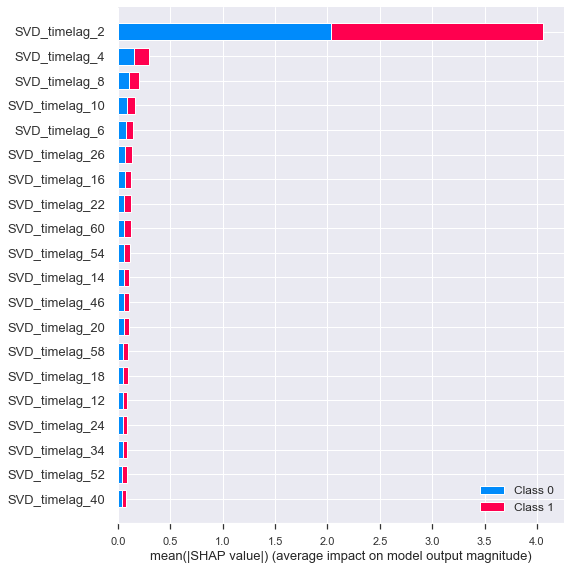

In [36]:
shap.summary_plot(shap_values, X_val)

## Тут самый главный вывод. Благодаря этому анализу мы можем установить интервал времени для принятия решения оператора. Так как лаг=2, то у оператора будет 4 минуты посмотреть на скор модели и принять решение. Далее для оценки будущего состояния мы будем оценивать данные за период 4-20 минут, это даст нам устойчивую метрику. При подходе с окном скор нашей модели будет увеличиваться с вероятность обрыва.


##  Мы контролим обрывность на ST110, но нам нужна модель, которая будет смотреть на показатели других station (агрегатах) + на другие метрики. Условно говоря, нужно понять за какой период гранулы предобрабоются и поступят в финальный агрегат. Эти данные мне неизвестны. В любом случаем мы можем увеличить/уменьшить диапазон лагов для анализа/предикта под задачу.


## Теперь с учетом этого интервала можно собирать датафрейм для анализа.

## Feat engineer with best lags..

In [37]:
timelag_df = full_df[column_target].copy()
timelag_df['ST110_VAREx_0_SDickeIst_NOW'] = timelag_df['ST110_VAREx_0_SDickeIst'].apply(lambda x: 1 if x == 0 else 0)
timelag_df.drop('ST110_VAREx_0_SDickeIst', axis=1, inplace=True)
tmp_df = []
for n_lag in range(2, 11, 2):
    tmp_df = full_df.shift(periods = n_lag).dropna().copy()[columns_for_train]
    tmp_df.columns = [c+'_lag'+str(n_lag) for c in tmp_df.columns.tolist()]
    timelag_df = timelag_df.merge(tmp_df, how='inner', left_on=['Datum'], right_on=['Datum'])

In [38]:
timelag_df.head()

ST110_VAREx_0_SDickeIst_NOW  ST0_VARActAuftrag_lag2  ST110_VARExtr_0_HeizungZone_3_Regler_Y_lag2  ST110_VARExtr_0_HeizungZone_3_SollTemp_lag2  ST110_VARExtr_0_HeizungZone_4_Konfig_lag2  ST110_VARExtr_0_HeizungZone_4_Regler_X_lag2  ST110_VARExtr_0_HeizungZone_4_Regler_Y_lag2  ST110_VARExtr_0_HeizungZone_4_SollTemp_lag2  ST110_VARExtr_0_HeizungZone_5_Konfig_lag2  ST110_VARExtr_0_HeizungZone_5_Regler_X_lag2  ST110_VARExtr_0_HeizungZone_5_Regler_Y_lag2  ST110_VARExtr_0_HeizungZone_5_SollTemp_lag2  ST110_VARExtr_0_HeizungZone_6_Konfig_lag2  ST110_VARExtr_0_HeizungZone_6_Regler_X_lag2  ST110_VARExtr_0_HeizungZone_6_Regler_Y_lag2  ST110_VARExtr_0_HeizungZone_6_SollTemp_lag2  ST110_VARExtr_0_HeizungZone_7_Konfig_lag2  ST110_VARExtr_0_HeizungZone_7_Regler_X_lag2  ST110_VARExtr_0_HeizungZone_7_Regler_Y_lag2  ST110_VARExtr_0_HeizungZone_7_SollTemp_lag2  ST110_VARExtr_0_HeizungZone_8_Konfig_lag2  ST110_VARExtr_0_HeizungZone_8_Regler_X_lag2  \
Datum                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2018-06-25 04:49:00                            0                     0.0                                          9.0                                        190.0                                        1.0                                        193.0                                          0.0                                        190.0                                        1.0                                        190.0                                         22.0                                        190.0                                        0.0                                         32.0                                          0.0                                        150.0                                        0.0                                         34.0                                          0.0                                        150.0                                        0.0                                         33.0   
2018-06-25 04:51:00                            0                     0.0                                         10.0                                        190.0                                        1.0                                        193.0                                          0.0                                        190.0                                        1.0                                        190.0                                         23.0                                        190.0                                        0.0                                         32.0                                          0.0                                        150.0                                        0.0                                         34.0                                          0.0                                        150.0                                        0.0                                         33.0   
2018-06-25 04:53:00                            0                     0.0                                         11.0                                        

In [39]:
y = np.array(timelag_df['ST110_VAREx_0_SDickeIst_NOW'])
timelag_df.drop(['ST110_VAREx_0_SDickeIst_NOW'], axis=1, inplace=True)

In [40]:
columns_for_train[:5]

['ST0_VARActAuftrag',
 'ST110_VARExtr_0_HeizungZone_3_Regler_Y',
 'ST110_VARExtr_0_HeizungZone_3_SollTemp',
 'ST110_VARExtr_0_HeizungZone_4_Konfig',
 'ST110_VARExtr_0_HeizungZone_4_Regler_X']

## Полный анализ с учетом всех показателей, лагов и собственно фичей по текущей даты(проверить будет не лишним).

Проверим еще дополнительно влияние даты и времени на обрывность при непрерывном производстве.

In [41]:
def prepare_data(X):
    X['dt_year'] = X.index.year
    X['dt_month'] = X.index.month
    X['dt_day'] = X.index.day
    X['dt_hour'] = X.index.hour
    X['dt_minute'] = X.index.minute
    X['dt_year_month_day'] = X.index.year*10000+X.index.month*100+X.index.day*1
    
    print('dt_year', X['dt_year'].unique())
    print('dt_month', X['dt_month'].unique())
    print('dt_day', X['dt_day'].unique())
    print('dt_hour', X['dt_hour'].unique())
    print('dt_minute', X['dt_minute'].unique())
    
    return X

In [42]:
full_timelag_df = timelag_df.copy()
full_timelag_df = prepare_data(full_timelag_df)
full_timelag_df.head()

dt_year [2018 2019]
dt_month [ 6  1  2  3  4  5  7  8  9 10 11 12]
dt_day [25 26 27 28 29 30  7 13 14 15 16 17 18 19 20 21 22 23 24 31  8  9 10 11
 12  1  2  3  4  5  6]
dt_hour [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3]
dt_minute [49 51 53 55 58  0  2  4  6  8 11 13 15 17 19 21 24 26 28 30 32 34 37 39
 41 43 45 47 50 52 54 56  3  5  7  9 16 18 20 22 29 31 33 35 42 44 46 48
 57 59  1 10 12 14 23 25 27 36 38 40]


ST0_VARActAuftrag_lag2  ST110_VARExtr_0_HeizungZone_3_Regler_Y_lag2  ST110_VARExtr_0_HeizungZone_3_SollTemp_lag2  ST110_VARExtr_0_HeizungZone_4_Konfig_lag2  ST110_VARExtr_0_HeizungZone_4_Regler_X_lag2  ST110_VARExtr_0_HeizungZone_4_Regler_Y_lag2  ST110_VARExtr_0_HeizungZone_4_SollTemp_lag2  ST110_VARExtr_0_HeizungZone_5_Konfig_lag2  ST110_VARExtr_0_HeizungZone_5_Regler_X_lag2  ST110_VARExtr_0_HeizungZone_5_Regler_Y_lag2  ST110_VARExtr_0_HeizungZone_5_SollTemp_lag2  ST110_VARExtr_0_HeizungZone_6_Konfig_lag2  ST110_VARExtr_0_HeizungZone_6_Regler_X_lag2  ST110_VARExtr_0_HeizungZone_6_Regler_Y_lag2  ST110_VARExtr_0_HeizungZone_6_SollTemp_lag2  ST110_VARExtr_0_HeizungZone_7_Konfig_lag2  ST110_VARExtr_0_HeizungZone_7_Regler_X_lag2  ST110_VARExtr_0_HeizungZone_7_Regler_Y_lag2  ST110_VARExtr_0_HeizungZone_7_SollTemp_lag2  ST110_VARExtr_0_HeizungZone_8_Konfig_lag2  ST110_VARExtr_0_HeizungZone_8_Regler_X_lag2  ST110_VARExtr_0_HeizungZone_8_Regler_Y_lag2  \
Datum                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2018-06-25 04:49:00                     0.0                                          9.0                                        190.0                                        1.0                                        193.0                                          0.0                                        190.0                                        1.0                                        190.0                                         22.0                                        190.0                                        0.0                                         32.0                                          0.0                                        150.0                                        0.0                                         34.0                                          0.0                                        150.0                                        0.0                                         33.0                                          0.0   
2018-06-25 04:51:00                     0.0                                         10.0                                        190.0                                        1.0                                        193.0                                          0.0                                        190.0                                        1.0                                        190.0                                         23.0                                        190.0                                        0.0                                         32.0                                          0.0                                        150.0                                        0.0                                         34.0                                          0.0                                        150.0                                        0.0                                         33.0                                          0.0   
2018-06-25 04:53:00                     0.0                                         11.0     

In [43]:
X_train, X_val, y_train, y_val = train_test_split(full_timelag_df, y, test_size=0.8, random_state=17, stratify=y)
params = {'metric': ('auc'), 'boosting_type': 'gbdt', 'objective': 'binary',
              'nthread': 8, 'early_stopping_rounds': 10,}
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
gbm = lgb.train(params, train_data, valid_sets = [train_data, val_data], valid_names=['train', 'val'], num_boost_round = 5000, verbose_eval = False)

In [44]:
print('Datapoint effect score: : ', '| val: ', gbm.best_score['val']['auc'], '| diff: ', 
      gbm.best_score['train']['auc'] - gbm.best_score['val']['auc'])

Datapoint effect score: :  | val:  0.9899343438003715 | diff:  0.009874211188841575


### Datapoint importance By gain

In [45]:
pd.DataFrame(list(zip(gbm.feature_name(), gbm.feature_importance(importance_type='gain')))).sort_values(1, ascending=False).head(25)

0             1
162   ST110_VAREx_1_Dos_0_IstLMGewicht_lag2  74654.277513
268   ST110_VAREx_3_Dos_0_IstLMGewicht_lag2  52832.467663
312             ST110_VAREx_3_GesamtDS_lag2  10713.868404
263            ST110_VAREx_2_SDickeIst_lag2   3254.748702
111       ST110_VARExtr_3_druck_1_IstP_lag2   2762.305616
220   ST110_VAREx_2_Dos_2_IstDurchsatz_lag2   2351.244291
154             ST110_VAREx_0_GesamtDS_lag2   1880.908531
358            ST112_VARAbzug_1_IstEin_lag2   1692.932050
323          ST110_VARIBC_1_Ist_n_Calc_lag2   1450.366034
327          ST110_VARIBC_3_Ist_n_Calc_lag2   1179.955274
355      ST110_VARUSBRegelungPosKlappe_lag2    901.055100
342       ST110_VARTrichter_10_Vorwahl_lag2    874.636690
352        ST110_VARTrichter_8_Vorwahl_lag2    459.341602
434                  ST114_VARCntStart_lag2    353.218303
2344                              dt_minute    288.389962
354        ST110_VARUSBRegelungIstwert_lag2    256.326651
1642     ST110_VAREx_2_Dos_4_IstAnteil_lag8    229.389500
2096   ST110_VAREx_2_Dos_2_SollAnteil_lag10    214.512800
436              ST114_VARDiaRollPanel_lag2    205.073609
795          ST110_VARIBC_3_Ist_n_Calc_lag4    204.955166
346       ST110_VARTrichter_17_Vorwahl_lag2    203.793767
789     ST110_VARGeblaese_2_Auslastung_lag4    173.537420
326         ST110_VARIBC_2_Soll_n_Visu_lag2    158.621528
2343                                dt_hour    143.616920
467                 ST114_VARWdTensVis_lag2    141.115339

### Datapoint importance By shap

In [46]:
shap_values = shap.TreeExplainer(gbm).shap_values(X_val)

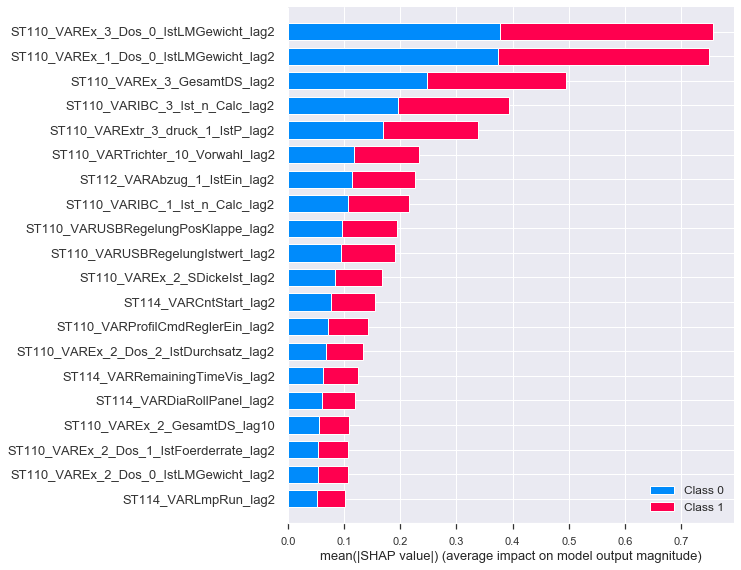

In [47]:
shap.summary_plot(shap_values, X_val)

### Как видно, тут мы скорее констатируем факт моделью, а не предсказываем будущее.


- Логично, что тут самые значимые фичи с наименьшим лагом и по станции S110, значения обрывности которого мы предсказываем. Это не очень хорошо:
1) есть вероятность переобучения: будущая модель будет иметь хуже метрики на предикте
2) обрывность пленки будет сильно коррелировать с показателям  S110_..._lag2 и будут нивелировать влияние других фичей и больших лагов в более ранних периодах
###  ПОЭТОМУ ЛАГИ ЛУЧШЕ СХЛОПНУТЬ МЕЖДУ СОБОЙ!


- Это имеет здравый смысл, что текущие дата и время влияет на обрыв пленки! - Хотел проверить гипотезу, что допустим, в январе после праздников % брака увеличивается, это будет означать человеческий фактор. Отбросим их


### Все это вместе смещает оценку влияния фичей в пользу более ранних лагов и снижает вероятность заблаговременного принятия решения оператора. Это не совсем корректно. Тут снова потребуется снижение размерности для более корректного анализа показаний. Снижать размерность будем по лагам и т.д.

## Схлопываем переменные только по Station.

In [48]:
st = list({c.split('_')[0] for c in columns_for_train})
st

['ST113', 'ST114', 'ST110', 'ST112', 'ST0']

Снизим размерность методом SVD как и ранее. Пропуски заменим медианой, так как мы не можем гарантировать нормальное распределение.

In [49]:
tmp_df = None
for num, cols_ in enumerate(st):
    cols = [c for c in timelag_df.columns if cols_ in c]
    tmp_df_ = timelag_df[cols].copy()
    imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
    tmp_df_ = imp_med.fit_transform(tmp_df_)
    scaler = StandardScaler().fit(tmp_df_)
    tmp_df_ = scaler.transform(tmp_df_)
    model_svd = TruncatedSVD(random_state=17, n_components=1).fit(tmp_df_)
    if num == 0:
        tmp_df = pd.DataFrame(model_svd.transform(tmp_df_), columns=['SVD_'+str(cols_)])
    else:
        tmp_df['SVD_'+str(cols_)] = model_svd.transform(tmp_df_)
tmp_df.head()

SVD_ST113  SVD_ST114  SVD_ST110  SVD_ST112  SVD_ST0
0  -4.246229  -4.713263 -10.581539  -3.030473      0.0
1  -4.802706  -4.536310 -10.548546  -3.030473      0.0
2  -4.315912  -4.776509 -10.611183  -3.063929      0.0
3  -4.859549  -4.799712 -10.569457  -3.063928      0.0
4  -4.039811  -4.576580 -10.585956  -3.097682      0.0

In [50]:
X_train, X_val, y_train, y_val = train_test_split(tmp_df, y, test_size=0.8, random_state=17, stratify=y)
params = {'metric': ('auc'), 'boosting_type': 'gbdt', 'objective': 'binary',
              'nthread': 8, 'early_stopping_rounds': 10,}
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
gbm = lgb.train(params, train_data, valid_sets = [train_data, val_data], valid_names=['train', 'val'], num_boost_round = 5000, verbose_eval = False)

In [51]:
print('Station effect score: ', '| val: ', gbm.best_score['val']['auc'], '| diff: ', 
      gbm.best_score['train']['auc'] - gbm.best_score['val']['auc'])

Station effect score:  | val:  0.9769239233668948 | diff:  0.01582875548784468


#### Качество чуть упало, но мы имеем укрупненную метрику, для оценки параметров агрегатов и лагов по ним в совокупности.

### Station importance By gain

In [52]:
gain = gbm.feature_importance(importance_type='gain')
total = sum(gain)
imp_station = pd.DataFrame({'Name_station': gbm.feature_name(), 'Value_station': gain/total})
imp_station = imp_station.sort_values('Value_station', ascending=False)
imp_station.index = range(1, imp_station.shape[0]+1)
imp_station.head(30)

Name_station  Value_station
1    SVD_ST114       0.556451
2    SVD_ST113       0.259785
3    SVD_ST110       0.134425
4    SVD_ST112       0.049338
5      SVD_ST0       0.000000

### Station importance By shap

In [53]:
shap_values = shap.TreeExplainer(gbm).shap_values(X_val)

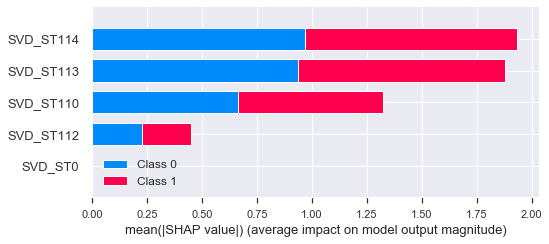

In [54]:
shap.summary_plot(shap_values, X_val)

### Просто отлично! Мы реально можем предсказывать обрывность пленки, которая измеряется по станции ST110 по состоянию дополнительным показателям со станций ST113 и ST114, когда смотрим метрики по лагам c SVD разложением!

## Со станций ST113 и ST114 снимаются метрики:
фактическая длина текущего рулона, длина предыдущего рулона, остальная длина текущего рулона, оставшееся время текущего рулона, установка длины текущего рулона, установка длины следующего рулона, установка общей длины, установка общего количества рулонов, пусковое положение, диаметр вала , счетчик часов работы, счетчик техничекого обслуживания, включение намотчика, установка диаметра текущего рулона, установка диаметра следующего рулона, фактический диаметр текщего рулона, первичный зажим, сдвиг первичного зажима, текущее положение первичного зажима, барабан намотки, скорость барабана намотки, статус барабана намотки, распределитель барабана намотки, толщина ( WD - width), начало отсчета длины барабана намотки, установочная длина текущего рулона, установочная длина следующего рулона, размер вала 

### Данные по этим агрегатам говорят скорей о влиянии режима производства на таргет. Нужно смотреть глубже:

## Схлопываем переменные только по datapoint.

In [55]:
datapoint = list({c.split('_')[1] for c in columns_for_train})
datapoint[:5]

['VARTargetLenActRoll',
 'VARCdSpeedHMI',
 'VARTrichter',
 'VARPnCloseCmd',
 'VARHoursCntAbzugWartung']

In [56]:
tmp_df = None
for num, cols_ in enumerate(datapoint):
    cols = [c for c in timelag_df.columns if cols_ in c]
    tmp_df_ = timelag_df[cols].copy()
    imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
    tmp_df_ = imp_med.fit_transform(tmp_df_)
    scaler = StandardScaler().fit(tmp_df_)
    tmp_df_ = scaler.transform(tmp_df_)
    model_svd = TruncatedSVD(random_state=17, n_components=1).fit(tmp_df_)
    if num == 0:
        tmp_df = pd.DataFrame(model_svd.transform(tmp_df_), columns=['SVD_'+str(cols_)])
    else:
        tmp_df['SVD_'+str(cols_)] = model_svd.transform(tmp_df_)
tmp_df.head()

SVD_VARTargetLenActRoll  SVD_VARCdSpeedHMI  SVD_VARTrichter  SVD_VARPnCloseCmd  SVD_VARHoursCntAbzugWartung  SVD_VARTotalRolls  SVD_VARTapeReductVal  SVD_VARRotationReverse  SVD_VARGapMax  SVD_VARGeblaese  SVD_VARGapEnable  SVD_VARClpReductVal  SVD_VARWendestangenSollwert180U  SVD_VARGesamtZeit  SVD_VARAbzug  SVD_VARPnSpTens  SVD_VARCdSpSpeed  SVD_VARReversierungSollWinkel  SVD_VAREx  SVD_VARPnEdgeCmd  SVD_VARWendestangenSollwert360O  SVD_VARClpEnable  SVD_VARCdEnable  SVD_VARPnSpSpeed  SVD_VARClpNum  SVD_VARDiaRollRc  SVD_VARRemainingLen  SVD_VARWdSpSpeed  SVD_VARTensPlusSp  SVD_VARRemainingTimeVis  SVD_VARReversierungZeit  SVD_VARUSBRegelungRegelungEin  SVD_VARTotalLen  SVD_VARUSBRegelungPosKlappe  SVD_VARSwdSpSpeed  SVD_VARSwdSpeedHMI  SVD_VARReversierungSollEin  SVD_VARTapeNum  SVD_VARDiaShaft  SVD_VARWendestangenSollwert180O  SVD_VARTagZeit  SVD_VARWendestangenSollwert360U  SVD_VARPnSpeedHMI  SVD_VARCdTensVis  SVD_VARPivotLoadCmd  SVD_VARWdCloseCmd  SVD_VARClpTens  \
0                -1.572125          -0.998084         -2.40998          -0.919292                     3.926854           5.179957                   0.0                -2.88167      -0.281335        -0.367971          -0.27628                  0.0                        -0.803934           4.617229     -1.799299         0.950185               0.0                      -1.784613 -10.846210               0.0                         -0.80392         -0.041605        -1.208756               0.0            0.0         -0.304789            -1.303618               0.0          -1.081035                -1.476083                 0.617237                      -0.894733         5.440356                    -1.113528          -0.365879           -2.122433                   -1.122826             0.0        -0.015562                        -0.804094        4.617229                        -0.804527          -1.612799         -2.092244                  0.0          -1.713741       -0.663473   
1                -1.572125           0.359120         -2.40998          -0.919292                     3.926817           5.180300                   0.0                -2.88167      -0.281335        -0.539592          -0.27628                  0.0                        -0.803934           4.617506     -1.799299         0.950185               0.0                      -1.784613 -10.811357               0.0                         -0.80392         -0.041605        -0.234362               0.0            0.0         -0.304789            -1.353464               0.0          -1.081035                -1.477233                 0.617237                      -0.894733         5.440691                    -0.954963          -0.365879           -2.180971                   -1.122826             0.0        -0.015562                        -0.804094        4.617506                        -0.804527          -1.612799         -2.176728                  0.0          -1.713741       -0.841548   
2                -1.572125          -0.998084         -2.40998          -0.919292                     3.926773           5.180676                   0.0                -2.88167      -0.281335        -0.674839          -0.27628                  0.0                        -0.803934           4.617796     -1.813563         0.950185               0.0                      -1.784613 -10.887302               0.0                         -0.80392         -0.041605        -1.208756               0.0            0.0         -0.304789            -1.362607               0.0          -1.081035                -1.479221                 0.799233                      -0.894733         5.441033                    -1.164299          -0.365879           -2.161346                   -1.122826             0.0        -0.015562                        -0.804094        4.617796                        -0.804527          -1.641428         -2.106873                  0.0          -1.713741       -0.663473   
3                -1.572125           1.8574

In [57]:
X_train, X_val, y_train, y_val = train_test_split(tmp_df, y, test_size=0.9, random_state=17, stratify=y)
params = {'metric': ('auc'), 'boosting_type': 'gbdt', 'objective': 'binary',
              'nthread': 8, 'early_stopping_rounds': 10,}
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
gbm = lgb.train(params, train_data, valid_sets = [train_data, val_data], valid_names=['train', 'val'], num_boost_round = 5000, verbose_eval = False)

In [58]:
print('Datapoint effect score: : ', '| val: ', gbm.best_score['val']['auc'], '| diff: ', 
      gbm.best_score['train']['auc'] - gbm.best_score['val']['auc'])

Datapoint effect score: :  | val:  0.9863802057225616 | diff:  0.012141235715659726


### Datapoint importance By gain

In [59]:
gain = gbm.feature_importance(importance_type='gain')
total = sum(gain)
imp_datapoint = pd.DataFrame({'Name_variable': gbm.feature_name(), 'Value_datapoint': gain/total})
imp_datapoint = imp_datapoint.sort_values('Value_datapoint', ascending=False)
imp_datapoint.index = range(1, imp_datapoint.shape[0]+1)
imp_datapoint.head(30)

Name_variable  Value_datapoint
1   SVD_VARUSBRegelungRegelungEin         0.618649
2               SVD_VARPnCloseCmd         0.199556
3                    SVD_VARAbzug         0.029078
4                 SVD_VARTrichter         0.018081
5                 SVD_VARGeblaese         0.013818
6                       SVD_VAREx         0.012164
7                   SVD_VARLmpRun         0.010674
8      SVD_VARReversierungSollEin         0.009699
9                 SVD_VARCntStart         0.006167
10                    SVD_VARExtr         0.006118
11               SVD_VARWdTensVis         0.004236
12      SVD_VARUSBRegelungIstwert         0.004208
13            SVD_VARDiaRollPanel         0.004147
14                 SVD_VARPrevLen         0.004053
15                    SVD_VARKorb         0.004012
16               SVD_VARPnTensVis         0.003789
17               SVD_VARCdTensVis         0.003488
18                  SVD_VARActLen         0.003389
19    SVD_VARUSBRegelungPosKlappe         0.003244
20             SVD_VARSwdSpeedHMI         0.002996
21    SVD_VARHoursCntAbzugWartung         0.002934
22              SVD_VARTotalRolls         0.002388
23                     SVD_VARIBC         0.002341
24        SVD_VARRemainingTimeVis         0.002112
25        SVD_VARProfilCmdMessung         0.002078
26            SVD_VARRemainingLen         0.002039
27        SVD_VARTargetLenActRoll         0.002026
28              SVD_VARWdCloseCmd         0.001951
29                SVD_VARTotalLen         0.001944
30              SVD_VARGesamtZeit         0.001853

### Datapoint importance By shap

In [60]:
shap_values = shap.TreeExplainer(gbm).shap_values(X_val)

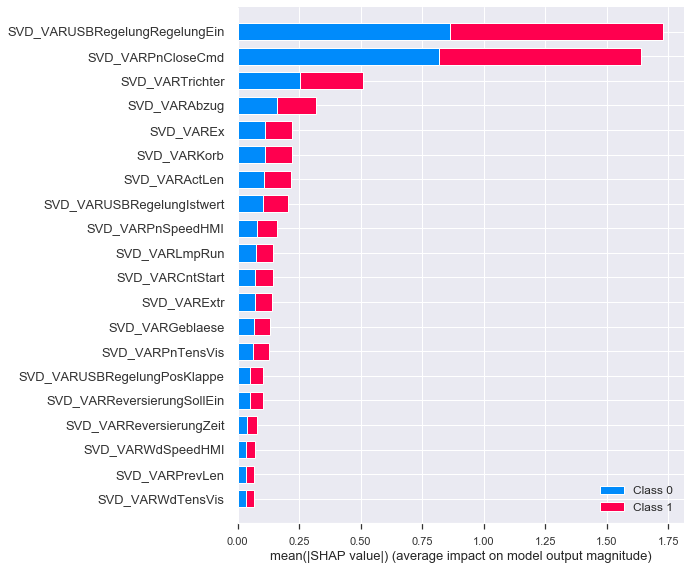

In [61]:
shap.summary_plot(shap_values, X_val)

In [63]:
shap_datapoint = pd.DataFrame({'Name_datapoint': gbm.feature_name(), 'Shap_datapoint': np.mean(np.abs(shap_values), axis=1)[0]}).sort_values('Shap_datapoint', ascending=False)
shap_datapoint.head(25)

Name_datapoint  Shap_datapoint
31  SVD_VARUSBRegelungRegelungEin        0.864047
3               SVD_VARPnCloseCmd        0.819346
2                 SVD_VARTrichter        0.255529
14                   SVD_VARAbzug        0.158432
18                      SVD_VAREx        0.110965
78                    SVD_VARKorb        0.109956
66                  SVD_VARActLen        0.108337
68      SVD_VARUSBRegelungIstwert        0.103309
42              SVD_VARPnSpeedHMI        0.080969
61                  SVD_VARLmpRun        0.073006
57                SVD_VARCntStart        0.072113
55                    SVD_VARExtr        0.069939
9                 SVD_VARGeblaese        0.065578
48               SVD_VARPnTensVis        0.063423
33    SVD_VARUSBRegelungPosKlappe        0.052529
36     SVD_VARReversierungSollEin        0.051350
30        SVD_VARReversierungZeit        0.040248
64              SVD_VARWdSpeedHMI        0.035436
79                 SVD_VARPrevLen        0.033327
80               SVD_VARWdTensVis        0.032408
70            SVD_VARDiaRollPanel        0.030445
22                SVD_VARCdEnable        0.028051
26            SVD_VARRemainingLen        0.027504
4     SVD_VARHoursCntAbzugWartung        0.027300
29        SVD_VARRemainingTimeVis        0.026699

### Гипотеза 1 обрывность зависит от режима производства
### Гипотеза 2 обрывность зависит от рецептуры
### Гипотеза 3 обрывность зависит человеческого фактора

## Если бы не делали лаги, то оценка смещалась бы в сторону гипотезы 1.

Рассмотрим топ 10 укрупненных показателей: 

- 0.864047 SVD_VARUSBRegelungRegelungEin контроль толщины на ST110 - Это уже констатация факта. Перед обрывом толщина начинается резко снижаться. Тут имеют место быть все 3 гипотезы.

- 0.819346 SVD_VARPnCloseCmd текущее положение первичного зажима ST113 - Гипотеза 1. Положение зажима будет зависеть от типа (толщины) пленки, которую мы производим. Если положение сместится, то это автоматически означает обрыв. Вряд ли тут оператор что-то решит.

- 0.255529 SVD_VARTrichter бункер предустановка ST110 - Гипотеза 3. Любая предустановка контролируется оператором на производстве - это очень большой риск человеческого фактора.

- 0.158432 SVD_VARAbzug показатели вытяжки ST112 - Общая кратность вытяжки - это отношение зазора щели к толщине пленки. При нагревании до температуры плавления полиэтилена пленка способна давать усадку. Явно несоблюдение режима производства. Гипотеза 1.

- 0.110965 SVD_VAREx параметры экструдера - Текущая толщина слоя / целевой % содержания в смеси компонента - Гипотеза 2. Допустим, превышен % вяжущих компонентов в массе смеси, что привело к нерегламентной скорости намотки.

- 0.109956 SVD_VARKorb фактический диаметр / установка диаметра ST110 - Гипотеза 3. Возможно, оператор не проконтролировал, что рулон закончился или он был слишком длинный для данного режима.

- 0.108337 SVD_VARActLen - фактическая длина текущего рулона на агрегатах ST113 и ST114. Скорее всего Гипотеза 1 и 3. Это будет как минимум хорошей фичей для предикта. 

- 0.103309 SVD_VARUSBRegelungIstwert ST110 - USB actual - Подключение USB явно может проконтролировать оператор... Гипотеза 3

- 0.080969 SVD_VARPnSpeedHMI - скорость барабана намотки на ST113 и ST114 + 0.073006 SVD_VARLmpRun включение намотчика ST113 и ST114 - Я так понимаю, что скорость намотки обратно пропорционально толщине пленки. При обрыве намотчики автоматически отключаются. Это скорее подводит к Гипотезе 1 - обрывность зависит от режима производства.

## Как-то неоднозначно! Все гипотезы имеют место быть. Посмотрим на конкретные метрики без укрупнения и уже финальные выводы будем делать по ним. Однако, мы видим, что наибольшее влияние на обрывность оказывает режим производства. Часть показателей может контролироваться оператором, а часть нет, значит человеческий фактор тоже имеет большое значение. Наименьшее влияние оказывает рецептура (если принять, что с качеством сырья нет проблем).

## Схлопываем по переменным, исключая влияние лагов.

In [64]:
variable = columns_for_train
variable[:5]

['ST0_VARActAuftrag',
 'ST110_VARExtr_0_HeizungZone_3_Regler_Y',
 'ST110_VARExtr_0_HeizungZone_3_SollTemp',
 'ST110_VARExtr_0_HeizungZone_4_Konfig',
 'ST110_VARExtr_0_HeizungZone_4_Regler_X']

In [65]:
tmp_df = None
for num, cols_ in enumerate(variable):
    cols = [c for c in timelag_df.columns if cols_ in c]
    tmp_df_ = timelag_df[cols].copy()
    imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
    tmp_df_ = imp_med.fit_transform(tmp_df_)
    scaler = StandardScaler().fit(tmp_df_)
    tmp_df_ = scaler.transform(tmp_df_)
    model_svd = TruncatedSVD(random_state=17, n_components=1).fit(tmp_df_)
    if num == 0:
        tmp_df = pd.DataFrame(model_svd.transform(tmp_df_), columns=['SVD_'+str(cols_)])
    else:
        tmp_df['SVD_'+str(cols_)] = model_svd.transform(tmp_df_)
tmp_df.head()

SVD_ST0_VARActAuftrag  SVD_ST110_VARExtr_0_HeizungZone_3_Regler_Y  SVD_ST110_VARExtr_0_HeizungZone_3_SollTemp  SVD_ST110_VARExtr_0_HeizungZone_4_Konfig  SVD_ST110_VARExtr_0_HeizungZone_4_Regler_X  SVD_ST110_VARExtr_0_HeizungZone_4_Regler_Y  SVD_ST110_VARExtr_0_HeizungZone_4_SollTemp  SVD_ST110_VARExtr_0_HeizungZone_5_Konfig  SVD_ST110_VARExtr_0_HeizungZone_5_Regler_X  SVD_ST110_VARExtr_0_HeizungZone_5_Regler_Y  SVD_ST110_VARExtr_0_HeizungZone_5_SollTemp  SVD_ST110_VARExtr_0_HeizungZone_6_Konfig  SVD_ST110_VARExtr_0_HeizungZone_6_Regler_X  SVD_ST110_VARExtr_0_HeizungZone_6_Regler_Y  SVD_ST110_VARExtr_0_HeizungZone_6_SollTemp  SVD_ST110_VARExtr_0_HeizungZone_7_Konfig  SVD_ST110_VARExtr_0_HeizungZone_7_Regler_X  SVD_ST110_VARExtr_0_HeizungZone_7_Regler_Y  SVD_ST110_VARExtr_0_HeizungZone_7_SollTemp  SVD_ST110_VARExtr_0_HeizungZone_8_Konfig  SVD_ST110_VARExtr_0_HeizungZone_8_Regler_X  SVD_ST110_VARExtr_0_HeizungZone_8_Regler_Y  SVD_ST110_VARExtr_0_HeizungZone_8_SollTemp  \
0                    0.0                                    2.043103                                    -1.90609                                       0.0                                    -0.97267                                   -0.375503                                   -1.880919                                       0.0                                   -1.576133                                    2.812566                                   -1.841872                                       0.0                                    2.436137                                         0.0                                   -0.370469                                       0.0                                    2.299829                                         0.0                                   -0.370469                                       0.0                                    2.303384                                         0.0                                   -0.370469   
1                    0.0                                    2.164470                                    -1.90609                                       0.0                                    -0.97267                                   -0.375503                                   -1.880919                                       0.0                                   -1.576133                                    2.812825                                   -1.841872                                       0.0                                    2.436137                                         0.0                                   -0.370469                                       0.0                                    2.299829                                         0.0                                   -0.370469                                       0.0                                    2.303384                                         0.0                                   -0.370469   
2                    0.0                                    2.159487                                    -1.90609                                       0.0                                    -0.97267                                   -0.375503                                   -1.880919                                       0.0                                   -1.576133                                    2.763764                                   -1.841872                                       0.0                                    2.324200                                         0.0                                   -0.370469                                       0.0                                    2.192522                                         0.0                                   -0.370469                                       0.0                                    2.303384                                         0.0                                   -0.370469   
3                    0.0                                   

In [66]:
X_train, X_val, y_train, y_val = train_test_split(tmp_df, y, test_size=0.8, random_state=17, stratify=y)
params = {'metric': ('auc'), 'boosting_type': 'gbdt', 'objective': 'binary',
              'nthread': 8, 'early_stopping_rounds': 10,}
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
gbm = lgb.train(params, train_data, valid_sets = [train_data, val_data], valid_names=['train', 'val'], num_boost_round = 5000, verbose_eval = False)

In [67]:
print('Variable effect score: : ', '| val: ', gbm.best_score['val']['auc'], '| diff: ', 
      gbm.best_score['train']['auc'] - gbm.best_score['val']['auc'])

Variable effect score: :  | val:  0.9893460202168 | diff:  0.010025504350589354


In [ ]:
### Метрика чуть повысилась относительно предыдущей итерации

### variable importance By gain

In [68]:
gain = gbm.feature_importance(importance_type='gain')
total = sum(gain)
imp_variable = pd.DataFrame({'Name_variable': gbm.feature_name(), 'Value_variable': gain/total})
imp_variable = imp_variable.sort_values('Value_variable', ascending=False)
imp_variable.index = range(1, imp_variable.shape[0]+1)
imp_variable.head(30)

Name_variable  Value_variable
1                         SVD_ST112_VARAbzug_1_IstZu        0.404947
2                        SVD_ST112_VARAbzug_1_IstEin        0.219819
3               SVD_ST110_VAREx_0_Dos_0_IstLMGewicht        0.205982
4                            SVD_ST113_VARPnCloseCmd        0.012062
5                      SVD_ST110_VAREx_0_RegelungEin        0.010889
6                                SVD_ST114_VARLmpRun        0.009294
7                        SVD_ST110_VAREx_2_SDickeIst        0.007444
8                   SVD_ST110_VARTrichter_10_Vorwahl        0.006837
9                      SVD_ST110_VARIBC_1_Ist_n_Calc        0.005275
10                   SVD_ST110_VARTrichter_8_Vorwahl        0.005205
11                  SVD_ST110_VAREx_3_DissipationPwr        0.003290
12  SVD_ST110_VARExtr_3_HeizungZone_4_ActEffectPower        0.002601
13                   SVD_ST110_VARUSBRegelungIstwert        0.002402
14                  SVD_ST110_VARTrichter_17_Vorwahl        0.002324
15                     SVD_ST110_VARIBC_3_Ist_n_Calc        0.002261
16               SVD_ST110_VARUSBRegelungRegelungEin        0.002085
17                SVD_ST110_VARGeblaese_1_Auslastung        0.001958
18                    SVD_ST110_VARIBC_2_Soll_n_Visu        0.001877
19                               SVD_ST114_VARActLen        0.001854
20                SVD_ST110_VAREx_2_Dos_2_SollAnteil        0.001832
21  SVD_ST110_VARExtr_2_HeizungZone_5_ActEffectPower        0.001631
22              SVD_ST110_VAREx_2_Dos_0_IstLMGewicht        0.001412
23        SVD_ST110_VARExtr_0_HeizungZone_5_Regler_Y        0.001370
24                  SVD_ST110_VARExtr_3_druck_1_IstP        0.001347
25                             SVD_ST114_VARCntStart        0.001297
26  SVD_ST110_VARExtr_2_HeizungZone_1_ActEffectPower        0.001242
27                SVD_ST110_VARGeblaese_2_Auslastung        0.001222
28                     SVD_ST112_VARReversierungZeit        0.001206
29                 SVD_ST110_VAREx_3_Dos_5_IstAnteil        0.001199
30        SVD_ST110_VARExtr_3_HeizungZone_1_Regler_Y        0.001191

### variable importance By shap

In [69]:
shap_values = shap.TreeExplainer(gbm).shap_values(X_val)

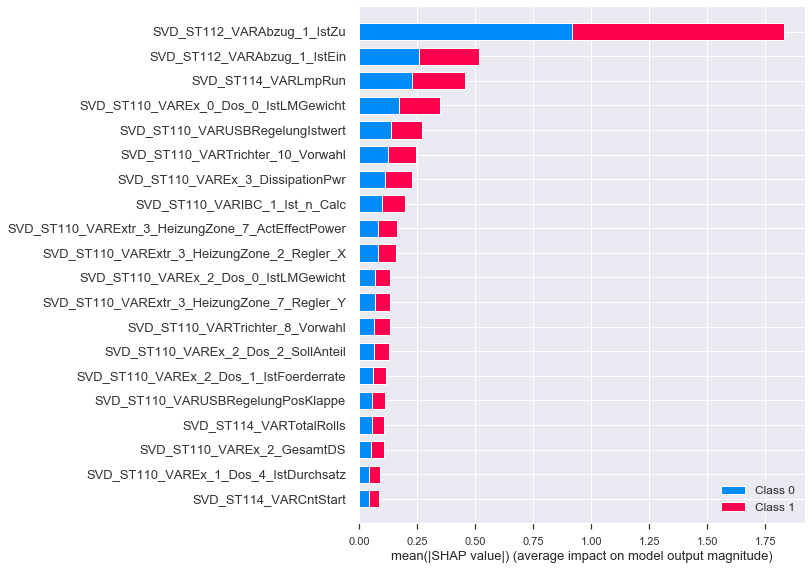

In [70]:
shap.summary_plot(shap_values, X_val)

In [72]:
shap_variable = pd.DataFrame({'Name_variable': gbm.feature_name(), 'Shap_variable': np.mean(np.abs(shap_values), axis=1)[0]}).sort_values('Shap_variable', ascending=False)
shap_variable.head(25)

Name_variable  Shap_variable
359                        SVD_ST112_VARAbzug_1_IstZu       0.915982
358                       SVD_ST112_VARAbzug_1_IstEin       0.258101
445                               SVD_ST114_VARLmpRun       0.227771
153              SVD_ST110_VAREx_0_Dos_0_IstLMGewicht       0.173778
354                   SVD_ST110_VARUSBRegelungIstwert       0.136126
342                  SVD_ST110_VARTrichter_10_Vorwahl       0.122815
267                  SVD_ST110_VAREx_3_DissipationPwr       0.113045
323                     SVD_ST110_VARIBC_1_Ist_n_Calc       0.098361
142  SVD_ST110_VARExtr_3_HeizungZone_7_ActEffectPower       0.082002
119        SVD_ST110_VARExtr_3_HeizungZone_2_Regler_X       0.080310
215              SVD_ST110_VAREx_2_Dos_0_IstLMGewicht       0.067242
145        SVD_ST110_VARExtr_3_HeizungZone_7_Regler_Y       0.066839
352                   SVD_ST110_VARTrichter_8_Vorwahl       0.066562
224                SVD_ST110_VAREx_2_Dos_2_SollAnteil       0.064580
217            SVD_ST110_VAREx_2_Dos_1_IstFoerderrate       0.058697
355                 SVD_ST110_VARUSBRegelungPosKlappe       0.055922
460                           SVD_ST114_VARTotalRolls       0.054284
259                        SVD_ST110_VAREx_2_GesamtDS       0.053454
187              SVD_ST110_VAREx_1_Dos_4_IstDurchsatz       0.044078
434                             SVD_ST114_VARCntStart       0.043676
346                  SVD_ST110_VARTrichter_17_Vorwahl       0.042553
266                          SVD_ST110_VAREx_2_SollLM       0.041721
263                       SVD_ST110_VAREx_2_SDickeIst       0.040559
401                            SVD_ST113_VARPnTensVis       0.039075
111                  SVD_ST110_VARExtr_3_druck_1_IstP       0.037616

# Финальные выводы будем делать на основе именно топ фичей по SHAP.

### Гипотеза 1 обрывность зависит от режима производства
### Гипотеза 2 обрывность зависит от рецептуры
### Гипотеза 3 обрывность зависит человеческого фактора


- SVD_ST112_VARAbzug_1_IstZu 0.915982 / SVD_ST112_VARAbzug_1_IstEin 0.258101 - остановка вытяжки / пуск вытяжки - При нагревании до температуры плавления полиэтилена пленка способна давать усадку. Явно несоблюдение режима производства. Гипотеза 1. Вытяжка позволяет варьировать скорость растяжения в широких пределах. Выход за пределы интервала скорости растяжения во время холодной вытяжки заготовки пленки , указанного в патентной формуле, приводит к ухудшению характеристик заявленных микропористых полиэтиленовых пленок: прочность не увеличивается, но снижается усадка. 


- SVD_ST114_VARLmpRun 0.227771 - включение намотчика - Намотка пленки может быть любой, главное, чтобы вес рулона не превышал нормативных значений, тогда намочтик может остановиться. Гипотеза 3, оператор мог это проконтролировать. Но, возможен вариант - намотчик остановился по причине разрыва, тогда имели место быть все гипотезы.


- SVD_ST110_VAREx_..._Dos_..._IstLMGewicht 0.173778 - фактический вес погонного метра - Это относится к качеству выходного продукта на конечном агрегате. Перед обрывом пленки отношение данного показателя от лага к лагу данного показателя будет падать. Гипотеза 1.


- SVD_ST110_VARUSBRegelungIstwert 0.136126 / SVD_ST110_VARUSBRegelungPosKlappe 0.055922 - USB actual - Подключение USB явно может проконтролировать оператор... А если USB подключено, то это явно интерфейс для контроля параметров. Однозначно Гипотеза 3 - человеческий фактор.


- SVD_ST110_VARTrichter_10_Vorwahl 0.122815 / SVD_ST110_VARTrichter_8_Vorwahl 0.066562 / SVD_ST110_VARTrichter_17_Vorwahl 0.042553 - предустановка бункера - Гранулы (или порошок) полиэтилена засыпаются в бункер. На этом этапе возможно применение специальных добавок для регулировки физических характеристик пленки и ее цвета. Это скорее говорит об ошибки оператора (любая предустановка контролируется оператором на производстве) - Гипотеза 2 и 3. Возможно, оператор установил парметры не для данной рецептуры, или это вообще не та рецептура.


- SVD_ST110_VAREx_3_DissipationPwr 0.113045 - производительность диссипации - Диссипация  — это переход части кинетической энергии в тепло трения. Показатель характеризует режим производства, я так понимаю возможны перегревы отдельных агрегатов, которые влияют на обрывность. Гипотеза 1. Возможна попадание соринки в аргегаты на поверхность пленки.


- SVD_ST110_VARIBC_1_Ist_n_Calc 0.098361 - фактический % приточного воздуха - Возможны негерметичны соединения подвода воздуха. Скорее всего гипотеза 1 - если режим производства не соблюдается с учетом толщины пленки. Возможна гипотеза 3 - если оператор чем-то закрыл подвод (закрыл курткой).


- SVD_ST110_VARExtr_3_HeizungZone_7_ActEffectPower 0.082002 / 119	SVD_ST110_VARExtr_3_HeizungZone_2_Regler_X	0.080310 - эффективная мощность нагрева зон агрегата / текущая температура - Тут 2 варианта: сильный перегрев по причине снижения фактического % приточного воздуха SVD_ST110_VARIBC_1_Ist_n_Calc. Второй вариант: какой-то агрегат вышел из стройя и уже не нагревает гранулы, что приводит автоматически к обрыву. Вероятнее гипотеза 1, с меньшей вероятностью гипотеза 3.


- SVD_ST110_VAREx_0_Dos_0_IstLMGewicht 0.067242 - счетчик фактической рабочей массы - Тут вероятны все 3 гипотезы в равной степени. Нельзя сказать однозначно.


- SVD_ST110_VARExtr_3_HeizungZone_7_Regler_Y 0.066839 - регулировка соотношения - 2 варианта -  Гипотеза 2 регулировка не соответствует данной рецептуре, Гипотеза 3 ошибка в настройках привела к некорректной регулировки - человеческий фактор.


- SVD_ST110_VAREx_2_Dos_2_SollAnteil 0.064580 - целевой % содержания в смеси компонента 1 - Гипотеза 2. Допустим, превышен % вяжущих компонентов в массе смеси, что привело к нерегламентной скорости намотки.


- SVD_ST110_VAREx_2_Dos_1_IstFoerderrate 0.058697 - фактическая скорость подачи компонента - Гипотеза 1 обрывность зависит от режима производства.


- SVD_ST114_VARTotalRolls 0.054284 - установка общего количества рулонов - Гипотеза 1. Предполагаю, что зависит от количества слоев на выходе. Но может и другая гипотеза, оператор мог ошибиться и не установить рулон куда нужно...


- SVD_ST110_VAREx_2_GesamtDS 0.053454 - Установленный выход кг/час - Гипотеза 1. Чем больше выпуск (интенсивность), тем вероятнее обрыв.


- SVD_ST114_VARCntStart	0.043676 - начало отсчета длины барабана намотки - Однозначно человеческий фактор. Как правило на таких установках есть отметка-рисочка на правильность установки барабана намотки. 


- SVD_ST110_VAREx_2_SollLM 0.041721 / SVD_ST110_VAREx_2_SollLM 0.041721 - Выход в погонных метрах / Текущая толщина слоя (на экструдере) - имеют место быть все 3 гипотезы.



# Предположение о наибольшем влиянии на обрывность пленки фактора режима производства пленки подтвердилось. Однако, на данной операции мы нашли больше узких мест, где мог повлиять человеческий фактор и рецептура производства (в меньшей степени)э